# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
%matplotlib inline
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from PIL import Image
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [2]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    dataset_dicts = []
    img_idx = -1
    for img_file in os.listdir(img_dir):
        if '.png' not in img_file:
            continue
        img_idx += 1
        img_file = os.path.join(img_dir, img_file)
        json_file = img_file.replace('png', 'json')
        with open(json_file) as f:
            img_ann = json.load(f)
        height, width = cv2.imread(img_file).shape[:2]
        record = {}

        record["file_name"] = img_file
        record["image_id"] = img_idx
        record["height"] = height
        record["width"] = width
        annos = img_ann["shapes"]

        objs = []
        for anno in annos:
            # assert not anno["points"]
            label = anno["label"]
            anno = anno["points"]
            px = [x[0] for x in anno]
            py = [x[1] for x in anno]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            id = 0
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                # XYXY指box是按左上角，右下角的坐标表示，ABS表示是绝对坐标。 REL表示相对图像的坐标（范围0-1）
                "bbox_mode": BoxMode.XYXY_ABS,
                # list[list[float]]类型,每个list[float]表示实例的一个联通区域（一个实例不一定是联通，可能被某些物体遮挡为多部分）
                "segmentation": [poly],
                "category_id": id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("Box_" + d, lambda d=d: get_balloon_dicts("BoxData/" + d))
    MetadataCatalog.get("Box_" + d).set(thing_classes=["Box"])
balloon_metadata = MetadataCatalog.get("Box_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



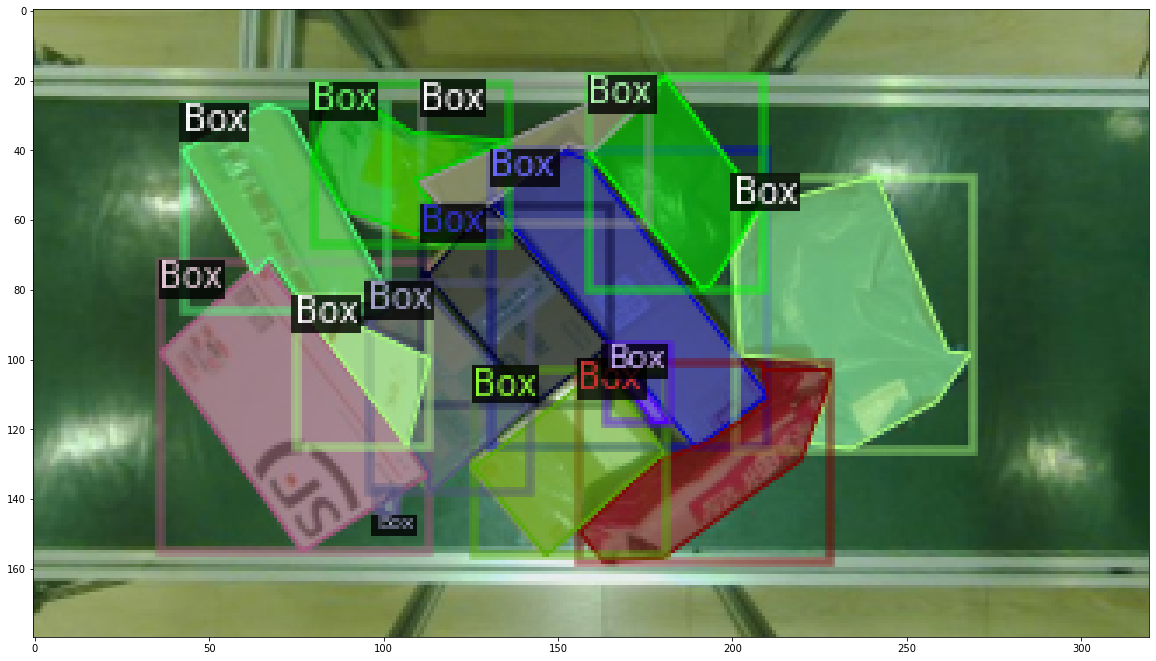

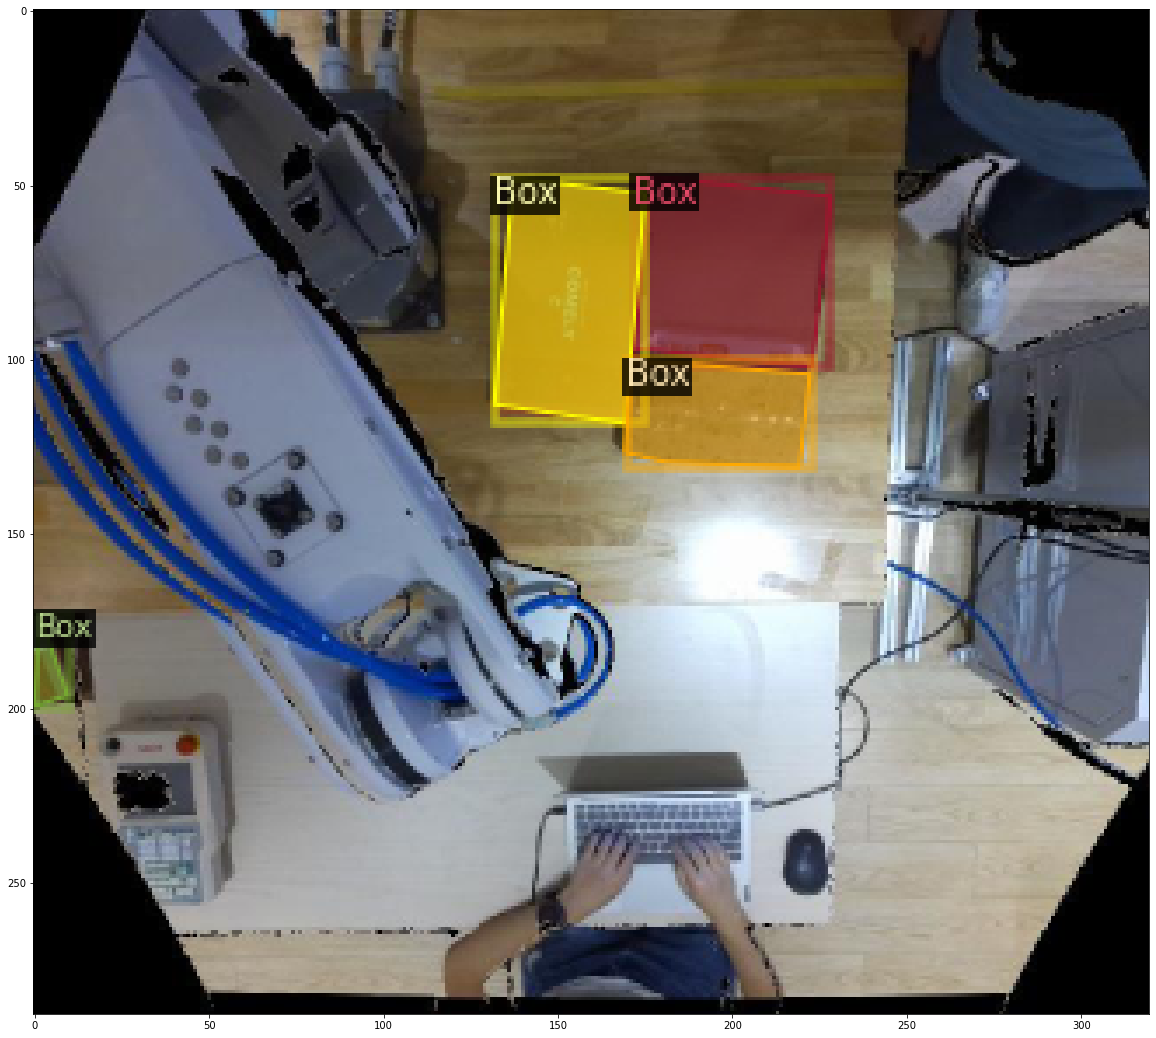

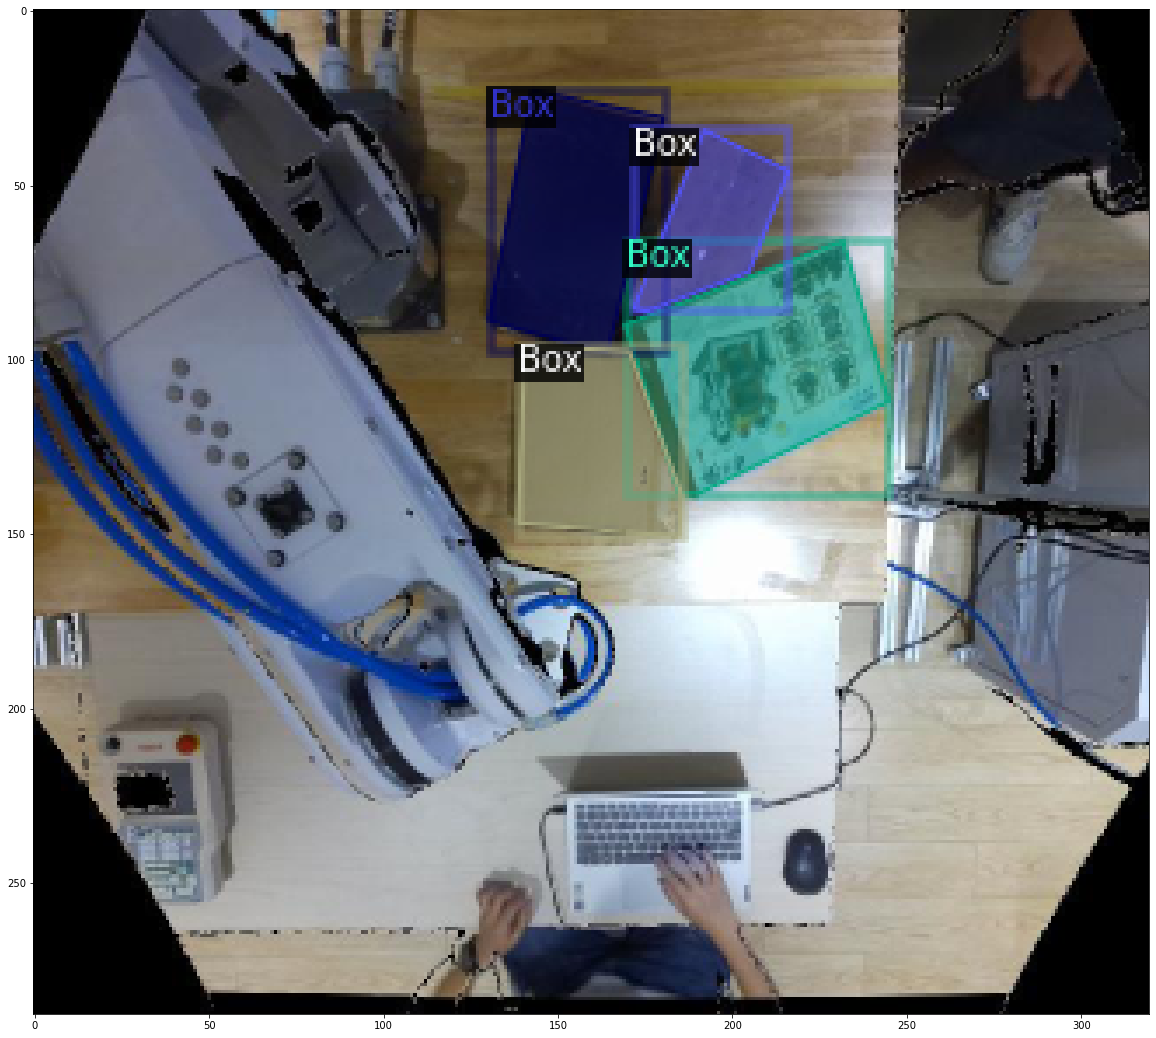

In [3]:
dataset_dicts = get_balloon_dicts("BoxData/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,20))
    plt.imshow(out.get_image())
    plt.show()

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Box_train",)
cfg.DATASETS.TEST = ("Box_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

m_features=512, eps=1e-05)
          )
          (conv3): Conv2d(
            512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=2048, eps=1e-05)
          )
        )
        (2): BottleneckBlock(
          (conv1): Conv2d(
            2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=512, eps=1e-05)
          )
          (conv2): Conv2d(
            512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=512, eps=1e-05)
          )
          (conv3): Conv2d(
            512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=2048, eps=1e-05)
          )
        )
      )
    )
  )
  (proposal_generator): RPN(
    (rpn_head): StandardRPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (objectness_logits): Conv2

FileNotFoundError: [Errno 2] No such file or directory: 'BoxData/val/210104_0029.json'

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("Box_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

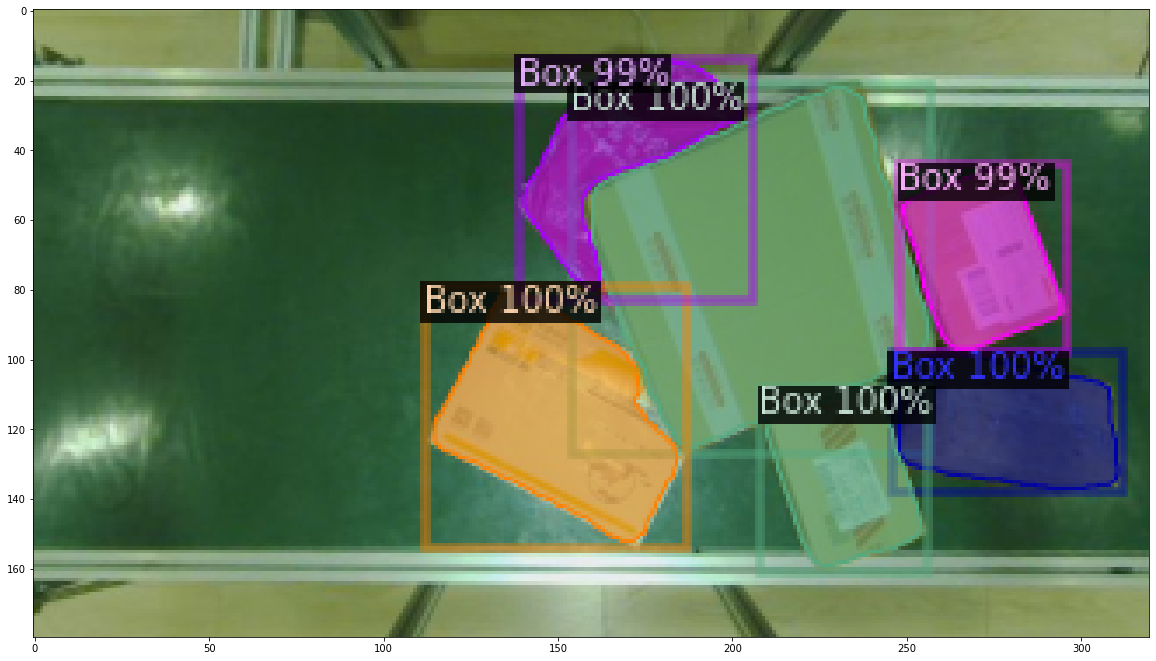

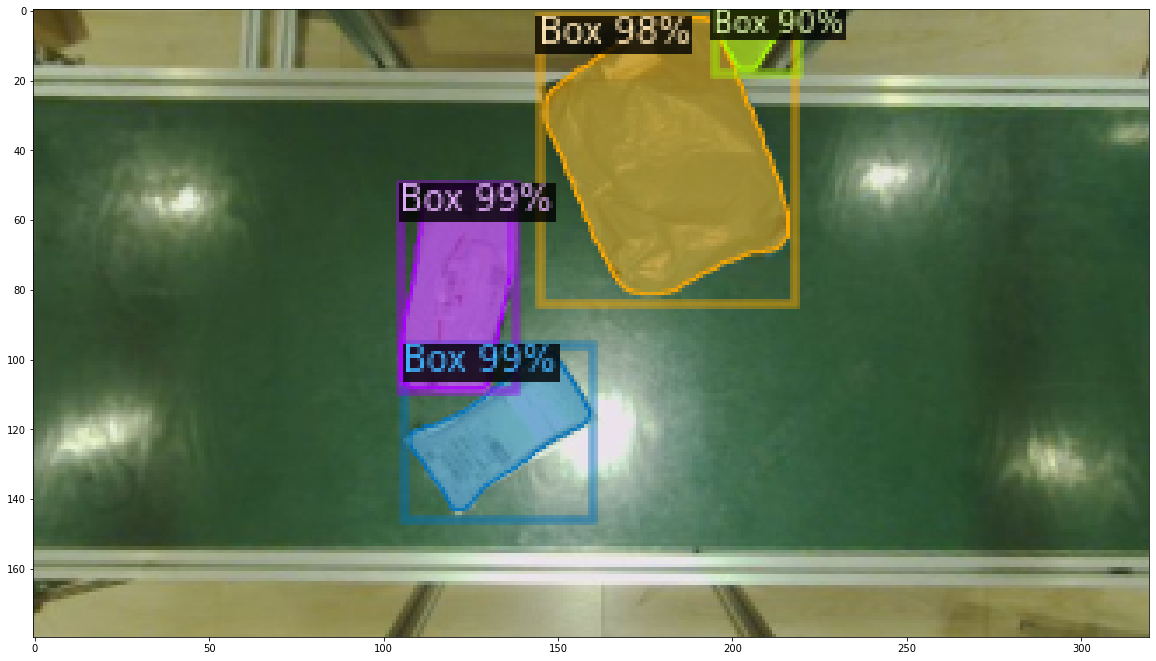

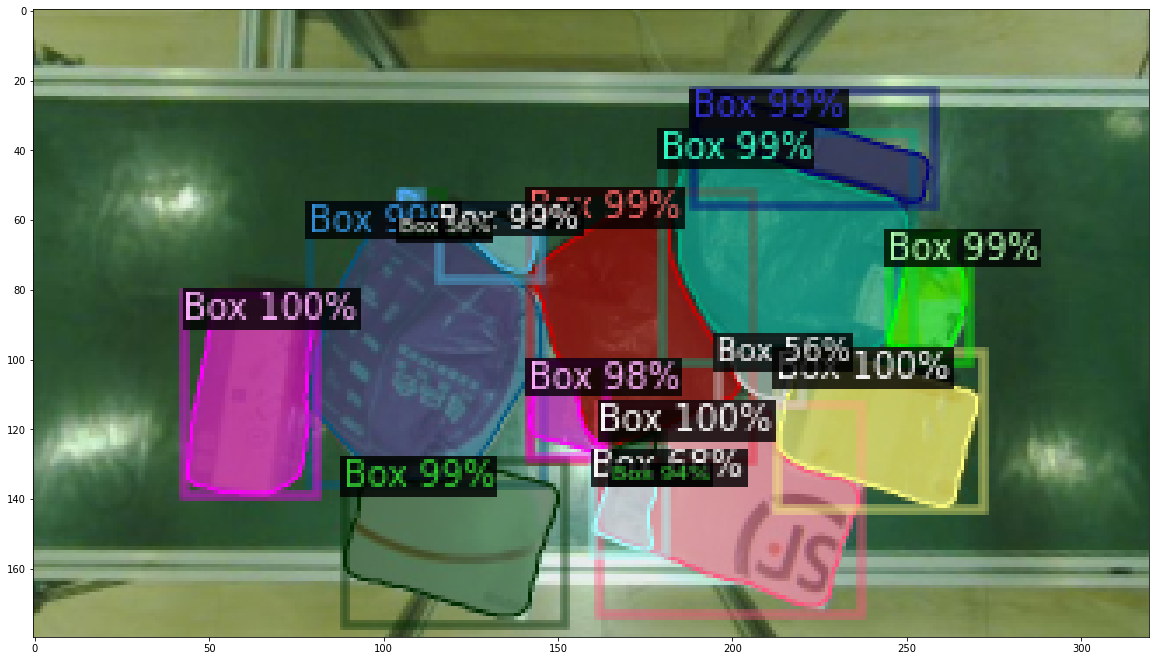

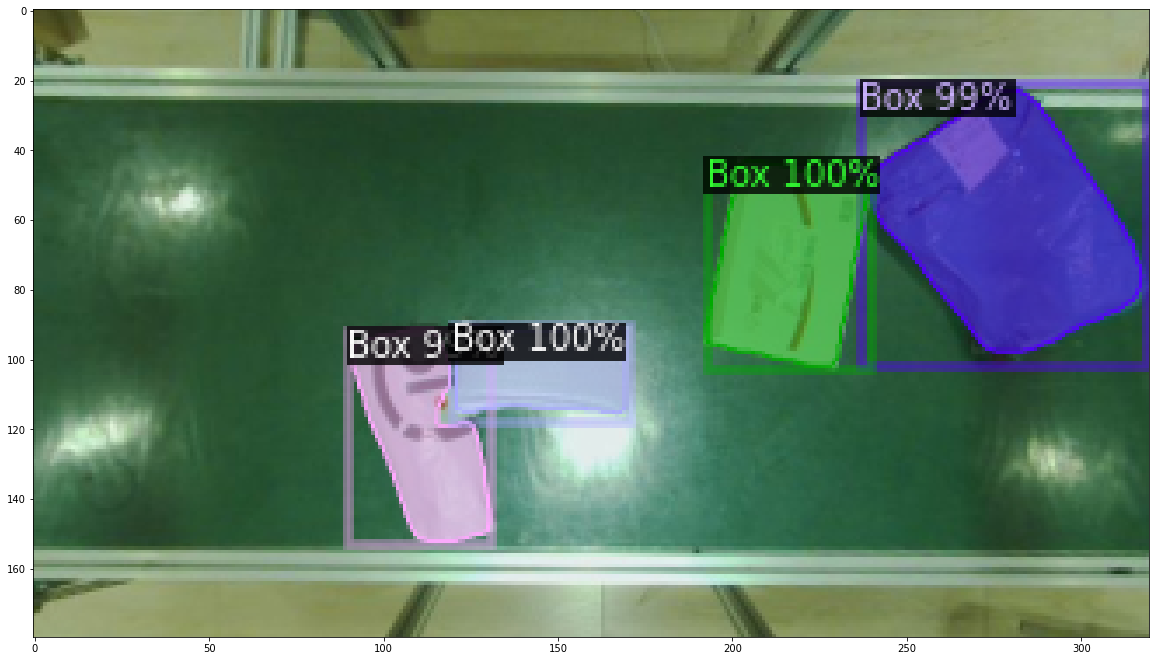

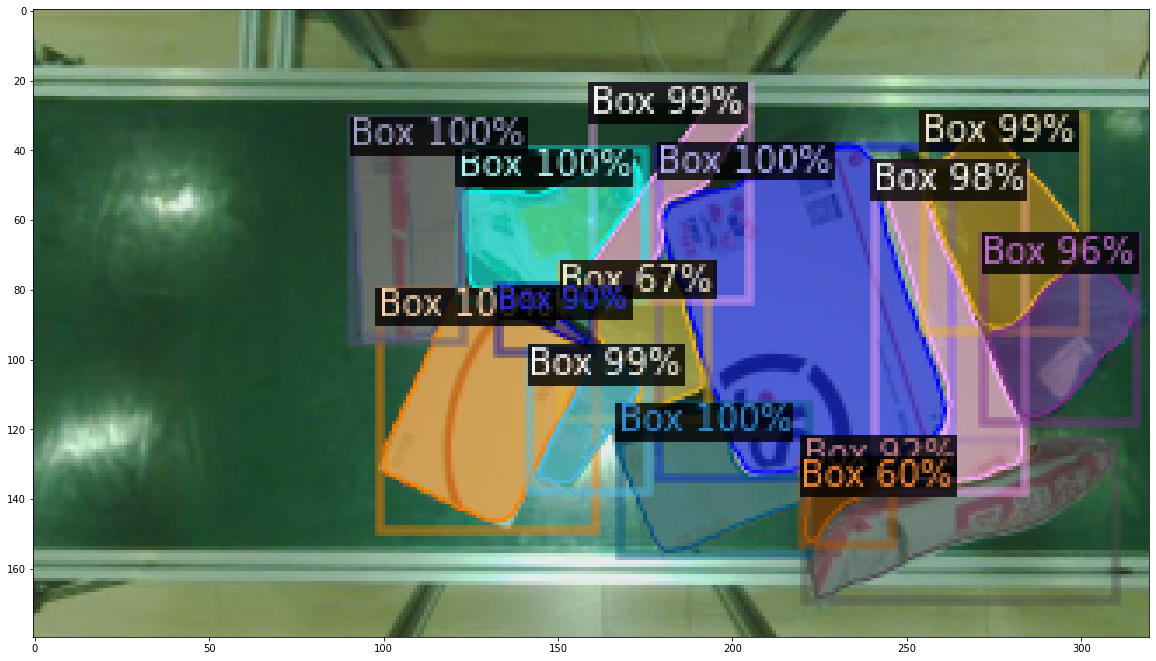

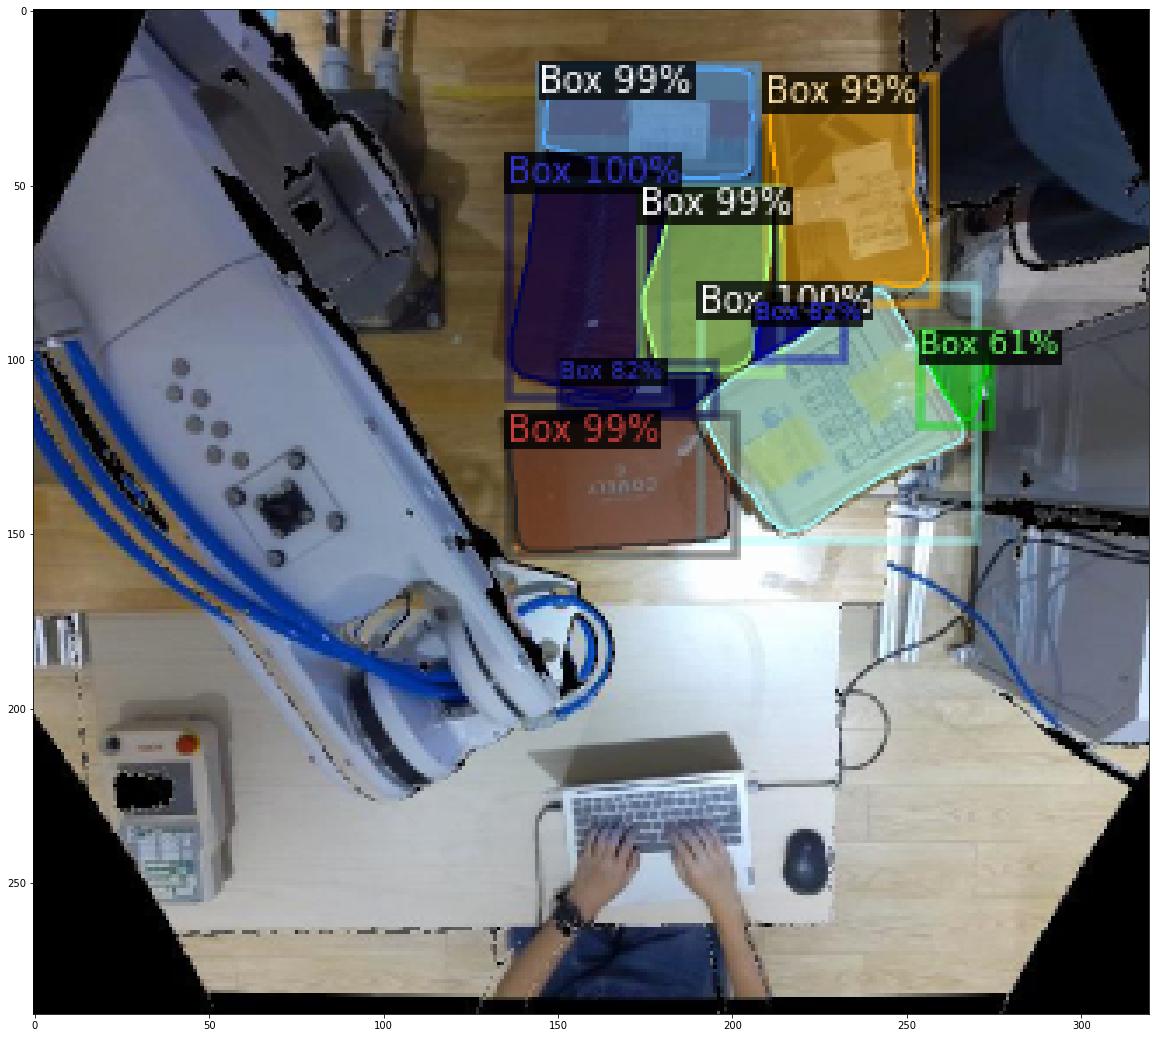

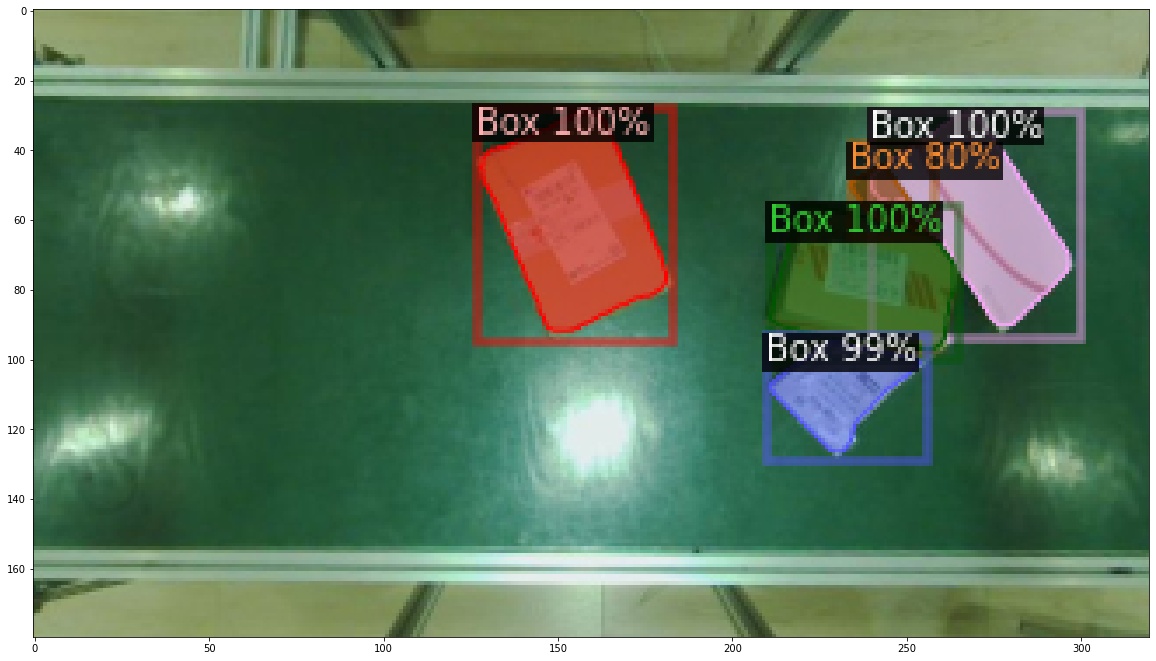

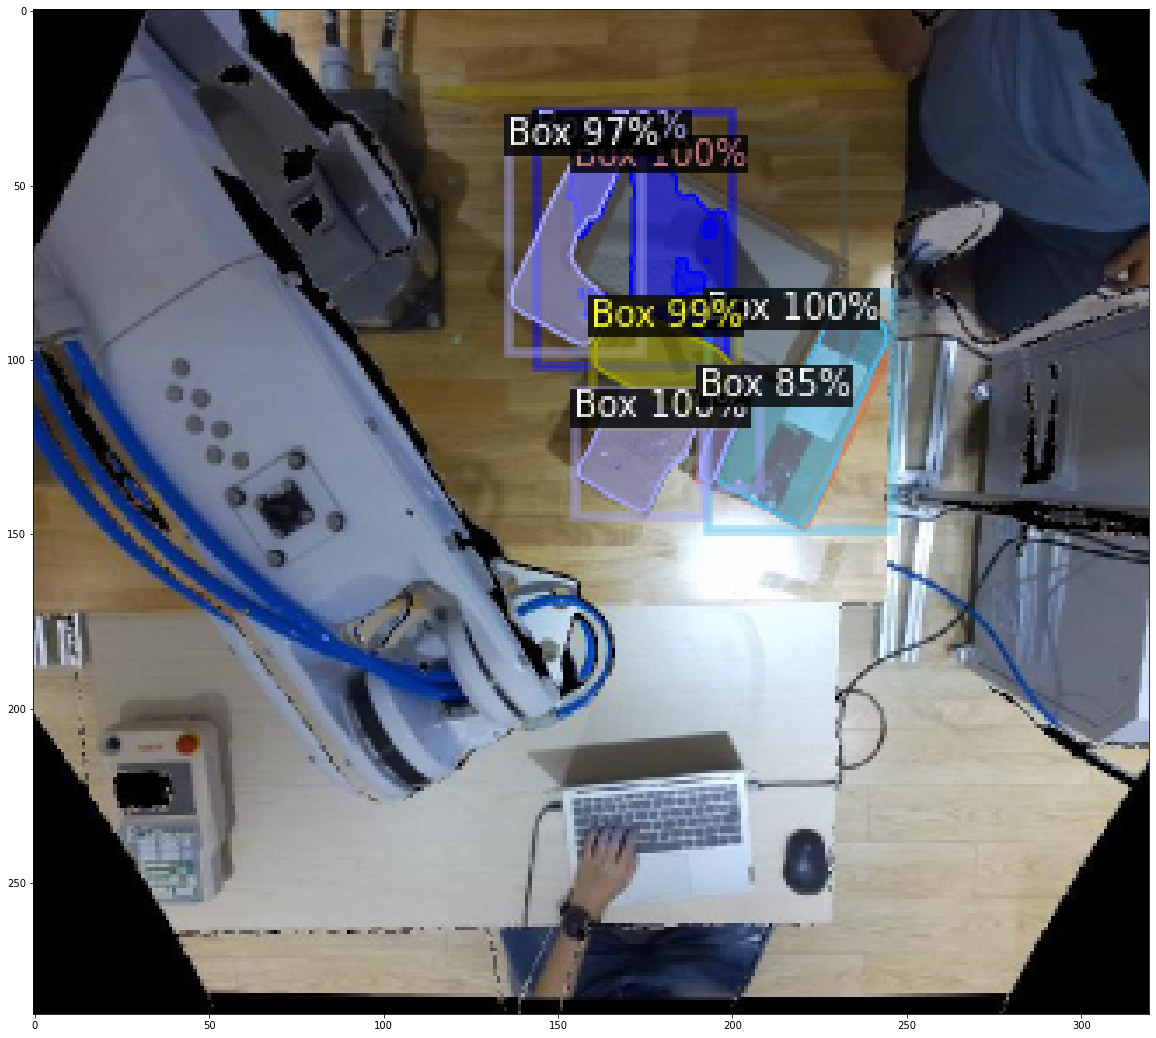

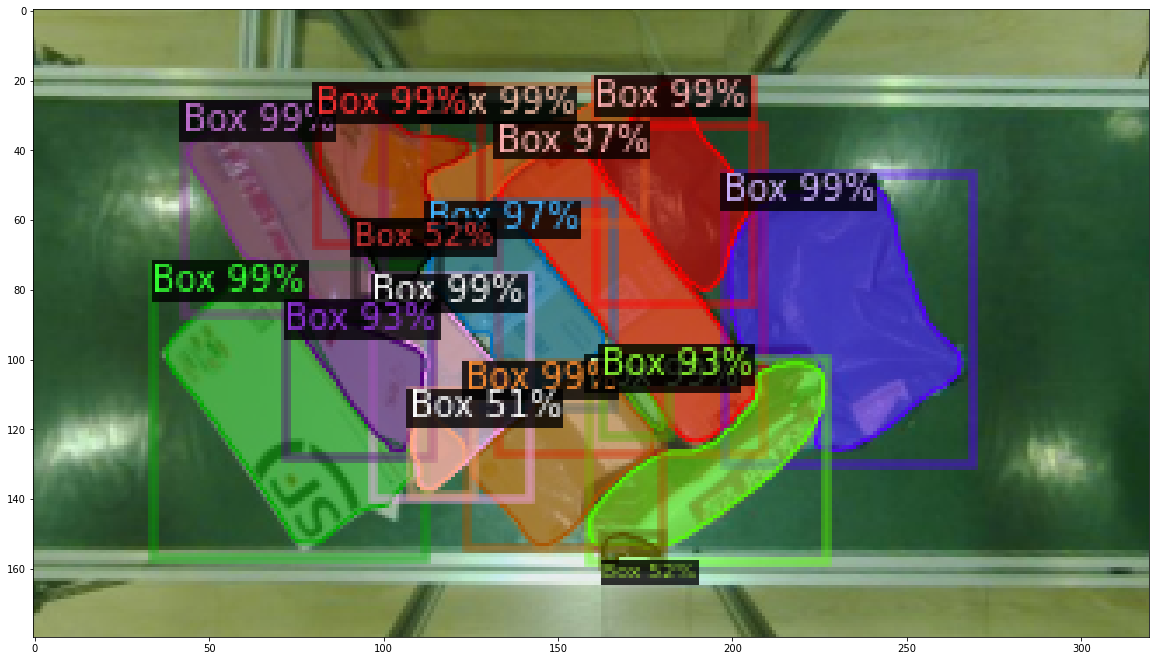

In [12]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("BoxData/val")
for d in random.sample(dataset_dicts, 9):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5
                  # instance_mode=ColorMode.IMAGE_RGB   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20, 20))
    plt.imshow(out.get_image()[:, :])
    plt.show()

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("Box_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "Box_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

[01/04 19:36:38 d2.evaluation.coco_evaluation]: 'Box_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/04 19:36:38 d2.data.datasets.coco]: Converting annotations of dataset 'Box_val' to COCO format ...)
[01/04 19:36:39 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/04 19:36:40 d2.data.datasets.coco]: Conversion finished, #images: 114, #annotations: 784
[01/04 19:36:40 d2.data.datasets.coco]: Caching COCO format annotations at './output/Box_val_coco_format.json' ...
[01/04 19:36:41 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Box     | 784          |
|            |              |
[01/04 19:36:41 d2.data.common]: Serializing 114 elements to byte tensors and concatenating them all ...
[01/04 19:36:41 d2.data.common]: Serialized dataset takes 0.22 MiB
[01/04 19:36:41 d2.data.dataset_mapper]: Augmentations used in training: [Re